# **Introduction à l'apprentissage automatique**

Il est maintenant temps de tenter de prédire le rendement d'avoine en fonction des variables que nous avons définies. 




Nous ne traiterons pas le jeu de données comme une série chronologique.  L'année, bien que présente, sera considérée comme une caractéristique dans le jeu de données.  
Nous ne voulons pas prédire le rendement futur en nous basant sur le passé.  Nous tenterons plutôt de prédire le rendement compte tenu des caractéristiques actuelles comme 
la température et la quantité de précipitations.

## Rappel 

Pour l'apprentissage supervisé, par convention, nous utilisons deux matrices, soient $X$ et $y$. 

$X$, contient les caractéristiques (*features*) et est de taille $n \times p$, où $n$ est le nombre d'exemples (observations) et $p$ est le nombre de caractéristiques (dimensionnalité).

$$X = \begin{bmatrix} 
f_{11} & f_{12} & \ldots & f_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
f_{n1} & f_{12} & \ldots & f_{np} \\
\end{bmatrix}
$$ 

$y$, est en fait un vecteur qui contient les étiquettes associées à chaque exemple. Il est donc de taille $n$. 


$$
y = \begin{bmatrix} 
e_1 \\
e_2 \\
\vdots \\ 
e_n
\end{bmatrix}$$



$X$ et $y$ doivent toujours être ordonnés de la même façon, i.e. pour un index $i$, les données de $X_i$ correspondent à l'étiquette $y_i$.



Comme nous entrainons des modèles sur un ensemble d'entrainement (`train`) et testons leurs performances sur un ensemble de test (`test`), nous dénotons ces ensembles comme $X_\text{train}$ et $X_\text{test}$ et $Y_\text{train}$ et $Y_\text{test}$.

## Installation et chargement des librairies nécessaires

In [389]:
#!pip install missingno
#!pip install statsmodels
#!pip install scikit-learn 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math


import missingno
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix


sns.set(font_scale=0.9, style='whitegrid')
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"]

In [390]:
df = pd.read_csv('dataset.csv', index_col=0)
df = df.loc[df.Rendement > 0, :].reset_index()
df = df.iloc[:,1:]

In [391]:
df.head()

,LATITUDE,LONGITUDE,MEAN_TEMPERATURE,MIN_TEMPERATURE,MAX_TEMPERATURE,TOTAL_PRECIPITATION,DAYS_WITH_VALID_PRECIP,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,DAYS_WITH_VALID_SNOWFALL,DAYS_WITH_VALID_SUNSHINE,Ensemencee,Recoltee,Rendement,Production_boiseaux,Production_tonnes,Annee,Region
0,45.66150,-82.466000,5.576735,-6.075,19.5500,655.550000,179.000000,77.500000,178.500000,179.00,0.0,827.386058,644.490193,16.173164,10.423445,0.160751,2013,Manitoulin
1,45.59300,-79.863667,0.623873,-13.775,15.3000,832.933333,237.666667,94.666667,90.466667,117.00,0.0,1350.905997,1041.065172,18.496898,19.256476,0.296975,2013,Parry Sound
2,48.70550,-93.031000,4.076841,-10.450,21.5250,873.300000,356.500000,108.500000,97.000000,177.50,0.0,2190.000000,2200.000000,20.768182,45.690000,0.704636,2019,Rainy River
3,51.02625,-91.028750,3.802137,-9.175,20.9375,529.500000,361.750000,79.750000,73.150000,93.25,0.0,302.000000,300.000000,23.000000,6.900000,0.106413,2006,Kenora
4,43.95850,-78.175000,2.968810,-10.100,18.5500,486.250000,196.000000,63.500000,19.000000,92.50,0.0,3010.000000,2410.000000,24.543568,59.150000,0.912217,2020,Northumberland


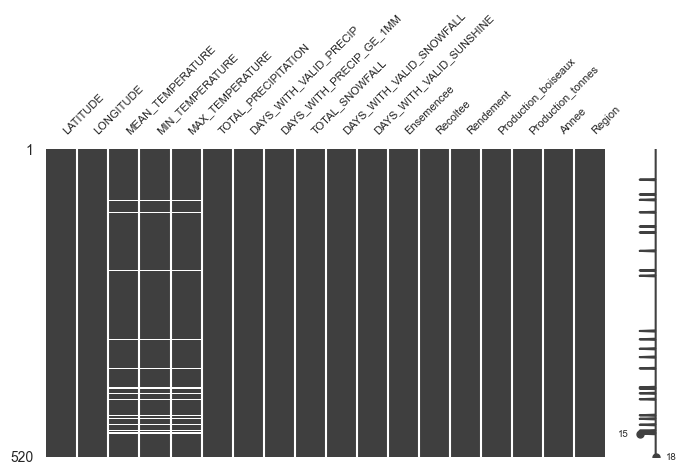

In [392]:
missingno.matrix(df, figsize=(8,4), fontsize=8)
plt.show()

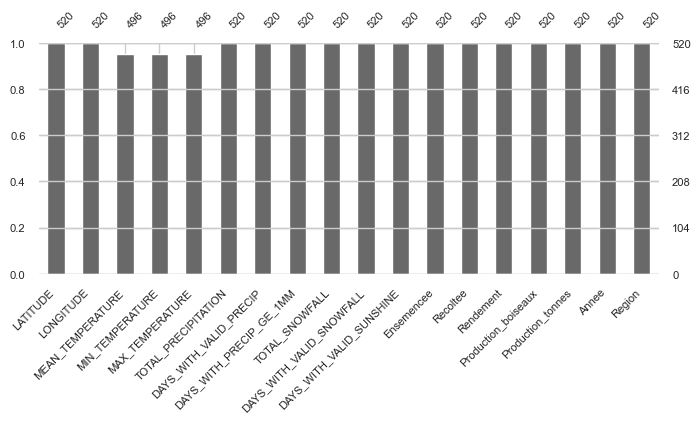

In [393]:
missingno.bar(df, figsize=(8,3), fontsize=8)
plt.show()

In [ ]:
df.isnull().any()

In [394]:
df.isna().sum(0)

LATITUDE                     0
LONGITUDE                    0
MEAN_TEMPERATURE            24
MIN_TEMPERATURE             24
MAX_TEMPERATURE             24
TOTAL_PRECIPITATION          0
DAYS_WITH_VALID_PRECIP       0
DAYS_WITH_PRECIP_GE_1MM      0
TOTAL_SNOWFALL               0
DAYS_WITH_VALID_SNOWFALL     0
DAYS_WITH_VALID_SUNSHINE     0
Ensemencee                   0
Recoltee                     0
Rendement                    0
Production_boiseaux          0
Production_tonnes            0
Annee                        0
Region                       0
dtype: int64


## Imputation des valeurs manquantes
Il existe plusieurs stratégies pour gérer les valeurs manquantes.  
Il faut faire bien attention pour ne pas introduire de biais et pour ne pas créer une fuite de données.



In [395]:
cols = ['DAYS_WITH_VALID_SUNSHINE','DAYS_WITH_VALID_PRECIP', \
        'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','DAYS_WITH_PRECIP_GE_1MM','TOTAL_SNOWFALL', \
        'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'Annee', 'LATITUDE']
#df = df.loc[pd.notnull(df.MAX_TEMPERATURE),:]
X = df.loc[:, cols]  # Caractéristiques (température, precipitation, etc.)
y = df.Rendement  # Valeurs cibles (rendement)

In [396]:
# Division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation des valeurs manquantes en utilisant 2 méthodes
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_train_mean = pd.DataFrame(imp.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_mean = pd.DataFrame(imp.transform(X_test), columns=X_test.columns, index=X_test.index)

imp_it = IterativeImputer(max_iter=10, random_state=0)
imp_it.fit(X_train)
X_train_it = pd.DataFrame(imp_it.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_it = pd.DataFrame(imp_it.transform(X_test), columns=X_test.columns, index=X_test.index)


### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Vérifiez que la valeur imputée pour la variable MEAN_TEMPERATURE est bien celle attendue. 

In [397]:
mean_val = df.loc[X_train.index, 'MEAN_TEMPERATURE'].mean()
print(F"La valeur moyenne de la variable MEAN_TEMPERATURE dans l'ensemble d'entrainement est de {round(mean_val, 6)}.")

print('Voici 2 rangées des valeurs imputées')
ix = df.loc[df.MAX_TEMPERATURE.isnull(),:].index

print("-----------------------")
print("Ensemble d'entrainement")

print("-----------------------")
print(X_train_mean.loc[X_train_mean.index.isin(ix),:].head(2))

print("-----------------------")
print("Ensemble de test")
print("-----------------------")
print(X_test_mean.loc[X_test_mean.index.isin(ix),:].head(2))

La valeur moyenne de la variable MEAN_TEMPERATURE dans l'ensemble d'entrainement est de 6.574392.
Voici 2 rangées des valeurs imputées
-----------------------
Ensemble d'entrainement
-----------------------
     DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
86                        0.0                   365.0          6.574392   
404                       0.0                   364.0          6.574392   

     MIN_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  \
86          -6.32446                    134.0           247.2   
404         -6.32446                    126.0           314.1   

     MAX_TEMPERATURE  TOTAL_PRECIPITATION   Annee  LATITUDE  
86         22.544982                987.8  2019.0    44.171  
404        22.544982               1112.5  2012.0    44.670  
-----------------------
Ensemble de test
-----------------------
     DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
307                       0.0                

In [398]:
print("Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative")
X_test_it.loc[X_test_it.index.isin(ix),:]

Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative


,DAYS_WITH_VALID_SUNSHINE,DAYS_WITH_VALID_PRECIP,MEAN_TEMPERATURE,MIN_TEMPERATURE,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,MAX_TEMPERATURE,TOTAL_PRECIPITATION,Annee,LATITUDE
307,0.0,88.0,6.657649,-5.521808,34.0,50.00,20.268005,215.3,2008.0,42.855
172,0.0,119.0,6.807785,-5.293181,45.0,24.00,20.186389,375.7,2012.0,42.855
77,0.0,365.0,7.338776,-5.404177,158.0,206.20,23.125456,1331.3,2013.0,43.002
478,0.0,366.0,7.009285,-6.191796,140.0,276.70,23.688535,1034.4,2016.0,43.863
131,0.0,179.5,6.967199,-5.144148,61.0,44.95,21.110851,509.1,2009.0,42.855


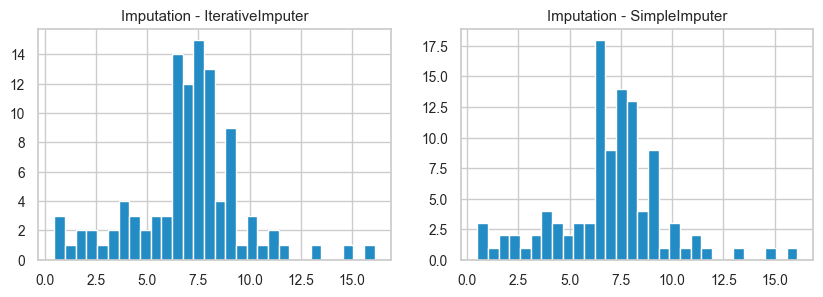

In [399]:
fig = plt.figure(figsize=(10,3))
nbins = 30
plt.subplot(121)
X_test_it.MEAN_TEMPERATURE.hist(bins=nbins, color=colors[1])
plt.title('Imputation - IterativeImputer')

plt.subplot(122)
X_test_mean.MEAN_TEMPERATURE.hist(bins=nbins, color=colors[1])
plt.title('Imputation - SimpleImputer')
plt.show()

Quelle methode d'imputation choisir ?

La documentation de scikit learn est très complète.  Il existe d'autres méthodes qui peuvent être utilisées. 

https://scikit-learn.org/stable/modules/impute.html

Lorsque nous parlons de données manquantes, il faut faire attention pour ne pas introduire de biais. Les données peuvent être manquantes par hasard ou elles peuvent être manquantes pour des raisons bien particulières.

Il existe trois types de données manquantes : 

* données manquantes complètement au hasard (MCAR : missing completely at random)
* données manquantes au hasard (MAR : missing at random) 
* données manquantes non au hasard (MNAR : missing not at random) 

Le type de données manquantes et le choix de méthode peuvent avoir un impact sur la qualitdé des données.

In [400]:
# Ici nous utilisons les données imputées par la méthode itérative
X_train = X_train_it
X_test = X_test_it

Il est important d'évaluer la corrélation entre les variables.  Les algorithmes d'apprentissage ne se comportent pas tous de la même façon.  Certains performent mieux avec des données gaussiennes, d'autres sont très sensibles aux valeurs numériques et une transformation est nécessaire, d'autres sont sensibles aux variables corrélées entre elles.

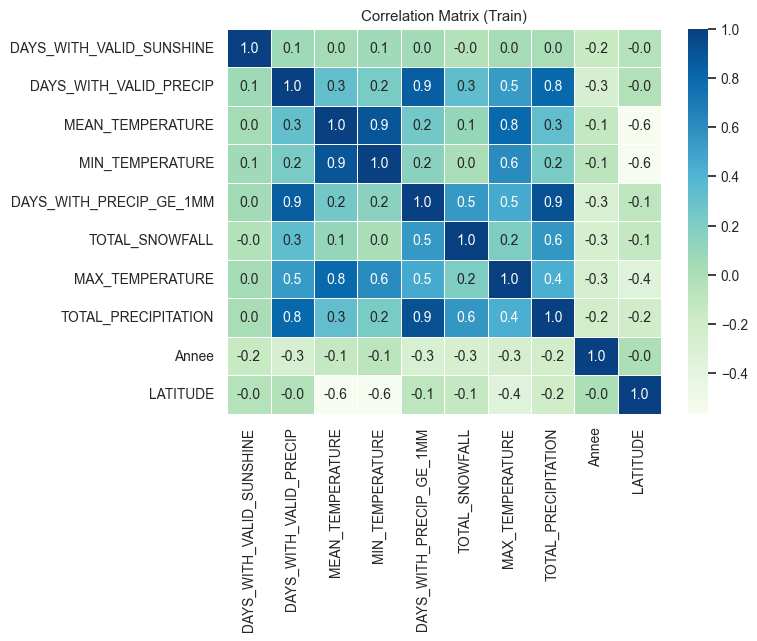

In [401]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

In [402]:
#plt.figure(figsize=(7,5))
#sns.heatmap(X_test.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Test)')
# plt.show()

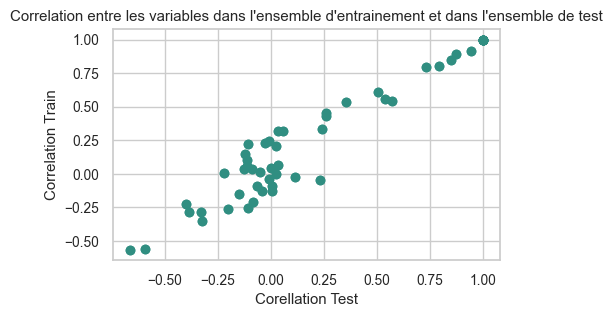

In [403]:
plt.figure(figsize=(5,3))
plt.scatter(X_test.corr(), X_train.corr(), color=colors[2])
plt.ylabel('Correlation Train')
plt.xlabel('Corellation Test')
plt.title ("Correlation entre les variables dans l'ensemble d'entrainement et dans l'ensemble de test")
plt.show()

Une transformation est parfois nécessaire, surtout lorsque  certains variables ont des valeurs beaucoup plus élevées que d'autres.
Ici, nous transformerons toutes les variables.

In [404]:
#https://scikit-learn.org/stable/modules/preprocessing.html

scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train_it)
X_test_scaled = scaler.transform(X_test_it)

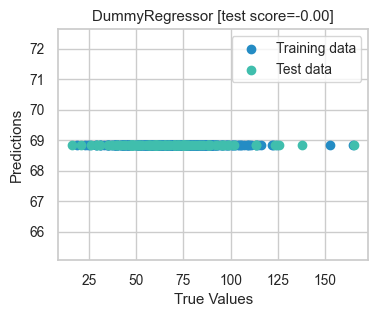

In [439]:

dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train_scaled, y_train)
y_pred = dummy_regressor.predict(X_test_scaled)
y_train_pred = dummy_regressor.predict(X_train_scaled)
score = dummy_regressor.score(X_test_scaled, y_test)

def plot_pred_vs_true(y_test, y_pred, score, model_name, y_train=None, y_train_pred=None):
    plt.figure(figsize=(4,3))
    
    if y_train is not None and y_train_pred is not None:
        plt.scatter(y_train, y_train_pred, label='Training data', color=colors[1])
        
    plt.scatter(y_test, y_pred, label='Test data', color=colors[0])
    plt.title('{} [test score={:.2f}]'.format(model_name, score))
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.show()


plot_pred_vs_true(y_test, y_pred, score, 'DummyRegressor', y_train=y_train, y_train_pred=y_train_pred)


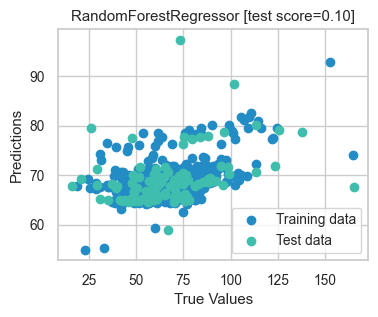

In [440]:
forest_regressor = RandomForestRegressor(max_depth=2, random_state=0)
forest_regressor.fit(X_train_scaled, y_train)
y_pred = forest_regressor.predict(X_test_scaled)
y_train_pred = forest_regressor.predict(X_train_scaled)
score = forest_regressor.score(X_test_scaled, y_test)
plot_pred_vs_true(y_test, y_pred, score, 'RandomForestRegressor', y_train=y_train, y_train_pred=y_train_pred)


Nous pouvons regarder quelles variables ont contribué le plus à la prédiction du rendement en récupérant la métrique d'importance.

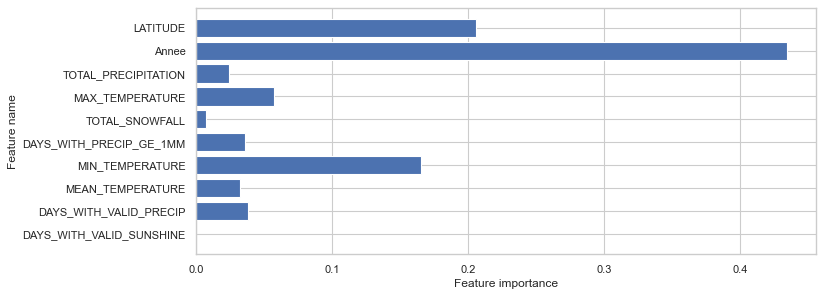

In [407]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train_scaled.columns)
plt.barh(range(c_features), forest_regressor.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train_scaled.columns)
plt.show()


Nous pouvons voir que l'année et la latitude sont les deux variables qui ont le plus contribuées.

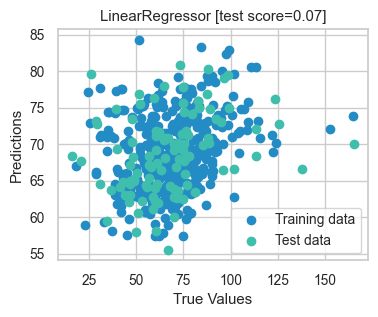

0.07181650364948344 0.07378777068017583


In [441]:

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)
test_score = linear_regressor.score(X_test_scaled, y_test)
train_score = linear_regressor.score(X_train_scaled, y_train)
y_pred = linear_regressor.predict(X_test_scaled)
y_train_pred = linear_regressor.predict(X_train_scaled)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)
print(train_score, test_score)


intercept: 68.85585088306607
coef: [('DAYS_WITH_VALID_SUNSHINE', -0.3625179784522527), ('DAYS_WITH_VALID_PRECIP', -0.727779465825577), ('MEAN_TEMPERATURE', -3.4544046082392015), ('MIN_TEMPERATURE', 2.7137819407496755), ('DAYS_WITH_PRECIP_GE_1MM', 6.802749469750661), ('TOTAL_SNOWFALL', -0.1332714732420321), ('MAX_TEMPERATURE', 0.46401945157623464), ('TOTAL_PRECIPITATION', -6.329300685833538), ('Annee', 4.101101100381846), ('LATITUDE', -2.1821484607498407)]


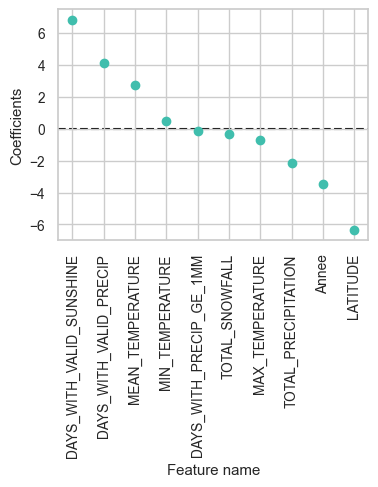

In [451]:
print('intercept:', linear_regressor.intercept_)
print('coef:', list(zip(X_train.columns, linear_regressor.coef_) ))
coefficients = pd.DataFrame(list(zip(X_train.columns, linear_regressor.coef_)), columns=['features', 'coefficients'])
coefficients.sort_values(by='coefficients', ascending=False, inplace=True)
plt.figure(figsize=(4,3))
#plt.barh(range(len(coefficients)), coefficients.coefficients)
plt.plot(range(len(coefficients)), coefficients.coefficients, marker='o', linestyle='none', color=colors[0])
plt.ylabel("Coefficients")
plt.xlabel("Feature name")
plt.xticks(np.arange(len(coefficients)), X_train_scaled.columns, rotation=90)
plt.axhline(y=0, color='black', linestyle='--', zorder=-1000)
plt.show()



Que peut-on observer ici ?

In [410]:
res = pd.DataFrame(list(zip(y_pred, y_test)), columns=['pred', 'test'], index=y_test.index)
res['Annee'] = df.loc[y_test.index, 'Annee'].astype(int)
res['Region'] = df.loc[y_test.index, 'Region']
res['Ensemencee'] = df.loc[y_test.index, 'Ensemencee']
res['Recoltee'] = df.loc[y_test.index, 'Recoltee']
res['Rendement'] = df.loc[y_test.index, 'Rendement']
res['diff'] = res.pred - res.test
res.sort_values('diff', inplace=True)

<Axes: >

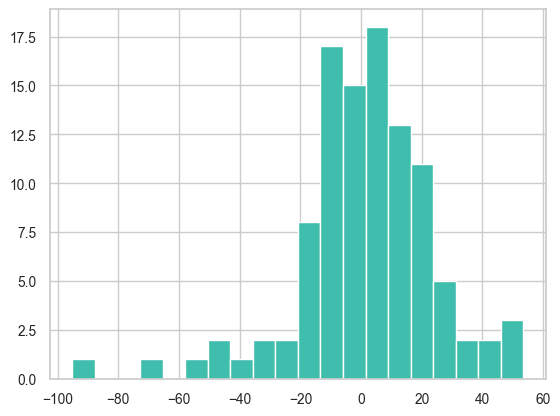

In [453]:
res['diff'].hist(bins=20, color=colors[0])

In [412]:
df.loc[(df.Region=='Durham')&(df.Annee==2013),:].T

,519
LATITUDE,44.1
LONGITUDE,-78.833
MEAN_TEMPERATURE,7.469577
MIN_TEMPERATURE,-7.5
MAX_TEMPERATURE,22.75
TOTAL_PRECIPITATION,948.0
DAYS_WITH_VALID_PRECIP,364.0
DAYS_WITH_PRECIP_GE_1MM,134.0
TOTAL_SNOWFALL,150.8
DAYS_WITH_VALID_SNOWFALL,364.0


In [413]:
X_test_scaled.loc[res.index[0:5],:]

,DAYS_WITH_VALID_SUNSHINE,DAYS_WITH_VALID_PRECIP,MEAN_TEMPERATURE,MIN_TEMPERATURE,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,MAX_TEMPERATURE,TOTAL_PRECIPITATION,Annee,LATITUDE
519,-0.117577,0.746643,0.296585,-0.311036,0.874571,0.498239,0.051918,0.641842,0.151581,-0.516029
516,-0.117577,0.606847,0.309522,-1.281218,-0.559866,0.159467,0.333849,-0.645206,1.626615,2.001580
515,-0.117577,0.632264,1.416261,0.879055,-0.376746,-1.040523,1.292416,0.070839,1.626615,-1.110855
513,-0.117577,0.683099,0.255386,1.260660,0.157353,-0.311958,0.305656,0.409934,1.073477,-0.993078
508,-0.117577,-0.181095,0.274831,-0.828467,-0.956625,-1.040523,0.390236,-0.867550,1.626615,1.549113


In [414]:
X_test_scaled.loc[res.index[-5:],:]

,DAYS_WITH_VALID_SUNSHINE,DAYS_WITH_VALID_PRECIP,MEAN_TEMPERATURE,MIN_TEMPERATURE,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,MAX_TEMPERATURE,TOTAL_PRECIPITATION,Annee,LATITUDE
10,-0.117577,-0.702153,0.770821,0.400431,-0.697205,-0.237469,0.827229,-1.170186,-0.032798,-0.893130
9,-0.117577,-1.572702,0.063724,0.588000,-1.689103,-1.040523,-1.470512,-1.380377,1.442236,0.379721
2,-0.117577,0.651327,-0.853975,-1.074246,0.096313,-0.050736,-0.293448,0.344187,1.257857,1.972136
0,-0.117577,-1.604474,-0.345324,0.057633,-0.849805,0.780890,-0.850263,-0.523474,0.151581,0.327586
6,-0.117577,-1.545166,0.553992,1.090339,-2.533488,-0.792226,0.549997,-2.536329,1.810994,-0.848649


In [415]:
# Autre package pour effectuer des regressions rapidement.  Nous allons l'utiliser pour calculer les p-values
X_sm = X_train_scaled.copy()
X_sm = sm.add_constant(X_sm)
model = sm.OLS(y_train, X_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Rendement   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.134
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           0.000715
Time:                        16:02:40   Log-Likelihood:                -1799.6
No. Observations:                 416   AIC:                             3621.
Df Residuals:                     405   BIC:                             3666.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Nous nous rendons compte que nous devons bien nous organiser pour tester différents pré-traitements, modèles et hyperparamètres. 
Ceci doit être fait en utilisant une stratégie de validation croisée pour s'assurer que le modèle final puisse généraliser à des données jamais vues.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    
<img src="https://scikit-learn.org/stable/_static/ml_map.png"/>

## Pipelines de Scikit Learn 

Comme on l'a vu, il y a plusieurs permutations possibles et on se retrouve vite avec plusieurs expériences à organiser.  Aussi, si on obtient un résultat intéressant, on veut savoir exactement les paramètres que nous avons utilisé.  Les pipelines de scikit learn nous aide à nous organiser et font sauver du temps et des lignes de code.  Nous pourrions aussi utiliser des logiciels comme kedro ou Knime.   L'auto ML est aussi de plus en plus populaire.

Un pipeline applique séquentiellement différentes opérations.

Dans les pipelines de scikit-learn, nous retrouvons 2 concepts importants:

* les transformateurs (transformer) qui offrent les fonctions <span style='font-family:monospace'>fit</span> et <span style='font-family:monospace'>transform</span>
* les estimateurs (estimators) qui offrent les fonctions <span style='font-family:monospace'>fit</span> et <span style='font-family:monospace'>predict</span>

In [416]:
results = []
estimator_names = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR', 'DummyRegressor']
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer(max_iter=10, random_state=0)),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    results.append([estimator, np.mean(scores), np.std(scores), 'Rendement'])
    
results = pd.DataFrame(results, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results

,Model,Mean Score,Std Score,Dataset
0,LinearRegression,-0.098940,0.155121,Rendement
1,RandomForestRegressor,-0.069685,0.197249,Rendement
2,DecisionTreeRegressor,-1.285111,0.738029,Rendement
3,KNeighborsRegressor,-0.161821,0.192503,Rendement
4,GradientBoostingRegressor,-0.193039,0.195117,Rendement
5,SVR,-0.072740,0.128729,Rendement
6,DummyRegressor,-0.081091,0.087091,Rendement


In [417]:
pipeline

Pipeline(steps=[('imputer', IterativeImputer(random_state=0)),
                ('scaler', StandardScaler()), ('estimator', DummyRegressor())])

In [418]:
# Making sure that the pipeline works
X_tmp, y_tmp = make_regression(n_samples=400, n_features=8)

results_tmp = []
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer()),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_tmp, y_tmp, cv=cv, n_jobs=-1)
    results_tmp.append([estimator, np.mean(scores), np.std(scores), 'scikit-learn'])
   
results_tmp = pd.DataFrame(results_tmp, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results_tmp

,Model,Mean Score,Std Score,Dataset
0,LinearRegression,1.000000,0.000000,scikit-learn
1,RandomForestRegressor,0.826415,0.029831,scikit-learn
2,DecisionTreeRegressor,0.548598,0.089125,scikit-learn
3,KNeighborsRegressor,0.778976,0.043924,scikit-learn
4,GradientBoostingRegressor,0.906327,0.011568,scikit-learn
5,SVR,0.095243,0.029352,scikit-learn
6,DummyRegressor,-0.032424,0.034043,scikit-learn


In [419]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # ou toute autre méthode de scaling que vous souhaitez tester

for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('imputer', None),
        ('scaler', None),  # L'emplacement où la méthode de scaling sera insérée
        ('estimator', eval(estimator)())  # Le modèle que vous souhaitez entraîner
    ])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()]
    }
    grid_search = GridSearchCV(pipeline, parameters, cv=10, scoring="r2")  # cv est le nombre de folds pour la validation croisée
    grid_search.fit(X_train, y_train)  # X sont vos données d'entraînement et y sont les étiquettes correspondantes
    #cv_results = grid_search.cv_results_
    #best_estimator = grid_search.best_estimator_   # Affiche le meilleur modèle

   
    print(estimator, grid_search.best_score_, grid_search.best_params_)  # Affiche la meilleure performance obtenue

LinearRegression -0.09893977245843724 {'imputer': SimpleImputer(), 'scaler': MinMaxScaler()}
RandomForestRegressor -0.04812782421831604 {'imputer': IterativeImputer(), 'scaler': StandardScaler()}
DecisionTreeRegressor -1.239597931822408 {'imputer': IterativeImputer(), 'scaler': MinMaxScaler()}
KNeighborsRegressor -0.12457743701549222 {'imputer': SimpleImputer(), 'scaler': MinMaxScaler()}
GradientBoostingRegressor -0.18426241773853363 {'imputer': IterativeImputer(), 'scaler': RobustScaler()}
SVR -0.06829495749497191 {'imputer': SimpleImputer(), 'scaler': MinMaxScaler()}
DummyRegressor -0.08109076563076847 {'imputer': SimpleImputer(), 'scaler': StandardScaler()}


Un coefficient de détermination négatif indique que quelque chose ne fonctionne pas.  Cela indique que le modèle de régression n'est pas capable de capturer la variation des données et qu'il effectue des prédictions moins précices qu'en utilisant simplement la moyenne.  

Quoi faire ?

* S'assurer que le code est correct 
* Tester plusieurs modèles
* Vérifier les données tant les variables prédictive que la variable à prédire
* Retourner aux données pour comprendre le problème

In [420]:
for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('imputer', None),
        ('scaler', None),  # L'emplacement où la méthode de scaling sera insérée
        ('estimator', eval(estimator)())  # Le modèle que vous souhaitez entraîner
    ])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()]
    }
    grid_search = GridSearchCV(pipeline, parameters, cv=10, scoring="r2")  # cv est le nombre de folds pour la validation croisée
    grid_search.fit(X_tmp, y_tmp)  # X sont vos données d'entraînement et y sont les étiquettes correspondantes
    #cv_results = grid_search.cv_results_

   
    print(estimator, grid_search.best_score_, grid_search.best_params_)  # Affiche la meilleure performance obtenue

LinearRegression 1.0 {'imputer': SimpleImputer(), 'scaler': StandardScaler()}
RandomForestRegressor 0.8265710248135194 {'imputer': IterativeImputer(), 'scaler': RobustScaler()}
DecisionTreeRegressor 0.5700801493572734 {'imputer': IterativeImputer(), 'scaler': StandardScaler()}
KNeighborsRegressor 0.7797069261747812 {'imputer': SimpleImputer(), 'scaler': MinMaxScaler()}
GradientBoostingRegressor 0.9059958309565015 {'imputer': SimpleImputer(), 'scaler': StandardScaler()}
SVR 0.1048639710123623 {'imputer': SimpleImputer(), 'scaler': MinMaxScaler()}
DummyRegressor -0.0324243418313128 {'imputer': SimpleImputer(), 'scaler': StandardScaler()}


# Crop prediction dataset from Kaggle

Ici, la tâche est une tâche de classification (et non de régression)


In [421]:
mf = pd.read_csv('../data/raw/Crop_recommendation.csv')
mf['label'] = mf.label.astype('category')

In [422]:
mf.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


## À votre tour  - Break room - équipe de 3
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' height='100px'>  </a>

Explorer les données à l'aide de graphiques et de tableaux (1-2 graphiques), comme nous avons fait la semaine dernière.

Suggestion : 
pairplot de seaborn

graphique de distribution

report avec 

nb de valeurs manquantes 


Qu'avez-vous observé?

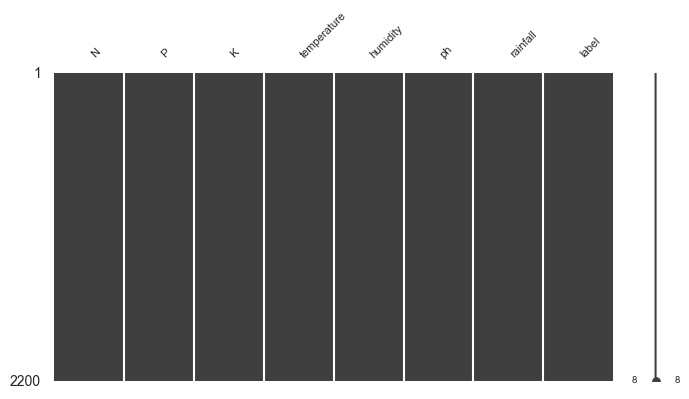

In [423]:
missingno.matrix(mf, figsize=(8,4), fontsize=8)
plt.show()

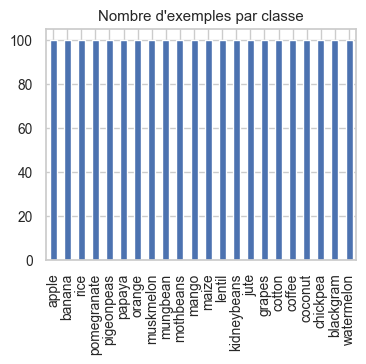

In [424]:

plt.figure(figsize=(4,3))
mf.label.value_counts().plot(kind='bar', title="Nombre d'exemples par classe")
plt.show()

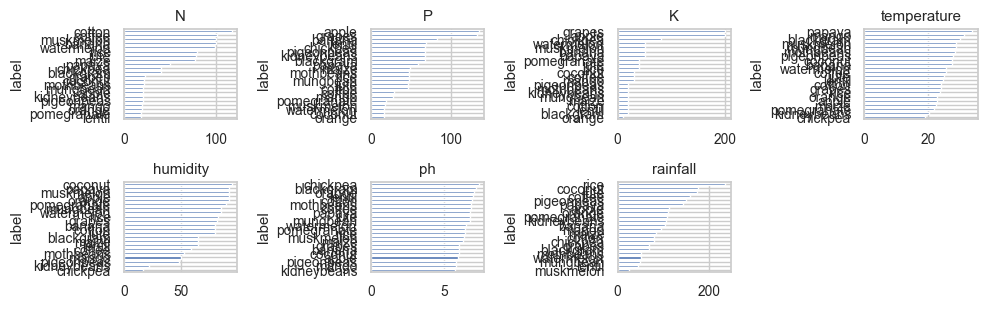

In [425]:
nc = 4
nr = math.ceil((len(cols)/nc)+1)
i = 1
g = mf.groupby('label')
fig = plt.figure(figsize=(10,6))
for col in mf.columns: 
    if col=='label':
        continue
    plt.subplot(nr,nc,i)
    g.mean()[col].sort_values().plot(kind='barh', title=col)
    i += 1
plt.tight_layout()
plt.show()

In [426]:
g.mean()

,N,P,K,temperature,humidity,ph,rainfall
label,,,,,,,
apple,20.80,134.22,199.89,22.630942,92.333383,5.929663,112.654779
banana,100.23,82.01,50.05,27.376798,80.358123,5.983893,104.626980
blackgram,40.02,67.47,19.24,29.973340,65.118426,7.133952,67.884151
chickpea,40.09,67.79,79.92,18.872847,16.860439,7.336957,80.058977
coconut,21.98,16.93,30.59,27.409892,94.844272,5.976562,175.686646
coffee,101.20,28.74,29.94,25.540477,58.869846,6.790308,158.066295
cotton,117.77,46.24,19.56,23.988958,79.843474,6.912675,80.398043
grapes,23.18,132.53,200.11,23.849575,81.875228,6.025937,69.611829
jute,78.40,46.86,39.99,24.958376,79.639864,6.732778,174.792798


In [427]:
values =g.loc[crop, :].values
values

AttributeError: 'DataFrameGroupBy' object has no attribute 'loc'

,N,P,K,temperature,humidity,ph,rainfall
label,,,,,,,
apple,0.020505,1.000000,0.998843,0.253053,0.967802,0.113541,0.415927
banana,0.822828,0.556302,0.210626,0.572618,0.814242,0.147701,0.377969
blackgram,0.214646,0.432736,0.048553,0.747457,0.618820,0.872127,0.204236
chickpea,0.215354,0.435455,0.367754,0.000000,0.000000,1.000000,0.261803
coconut,0.032424,0.003229,0.108259,0.574846,1.000000,0.143083,0.713962
coffee,0.832626,0.103595,0.104840,0.448968,0.538694,0.655665,0.630647
cotton,1.000000,0.252316,0.050237,0.344496,0.807642,0.732744,0.263406
grapes,0.044545,0.985638,1.000000,0.335110,0.833696,0.174185,0.212405
jute,0.602323,0.257585,0.157706,0.409772,0.805031,0.619426,0.709736


In [ ]:
#https://www.pythoncharts.com/matplotlib/radar-charts/

def radarplot(crop, color='doderblue', ax=None):
  g = mf.groupby('label').mean()
  features = g.columns
  # Normalisation
  g = (g - g.min(0)) / (g.max(0) - g.min(0))
  values = g.loc[crop, :].values
  num_features = len(features)
  angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
  if ax is None:
    _, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))
    #ax.plot(angles, values, color=color, linewidth=1, label=crop)
    #ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles), features)

    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
      if angle in (0, np.pi):
        label.set_horizontalalignment('center')
      elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
      else:
        label.set_horizontalalignment('right')

    # Ensure radar goes from 0 to 100.
    ax.set_ylim(0, 1)
    # You can also set gridlines manually like this:
    # ax.set_rgrids([20, 40, 60, 80, 100])

    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes.
    ax.set_rlabel_position(180 / num_features)
    ax.tick_params(colors='#222222')
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(color='#AAAAAA')
    ax.spines['polar'].set_color('#222222')
    ax.set_facecolor('#FAFAFA')

  
  
  ax.plot(angles, values, color=color, linewidth=1, label=crop)
  ax.fill(angles, values, color=color, alpha=0.25)
  ax.set_title(F"Caractéristiques", y=1.18)
  return ax

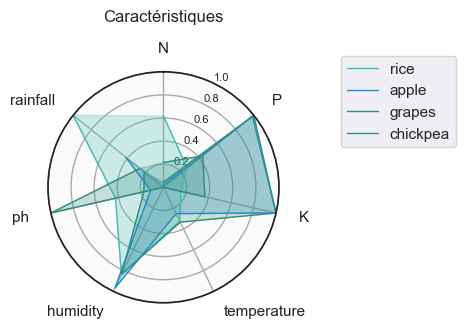

In [ ]:
ax = radarplot('rice', color=colors[0])
ax = radarplot('apple', color=colors[1], ax=ax)
ax = radarplot('grapes', color=colors[2], ax=ax)
ax = radarplot('chickpea', color=colors[2], ax=ax)
plt.legend(bbox_to_anchor=(1.8, 1.1))
plt.show()

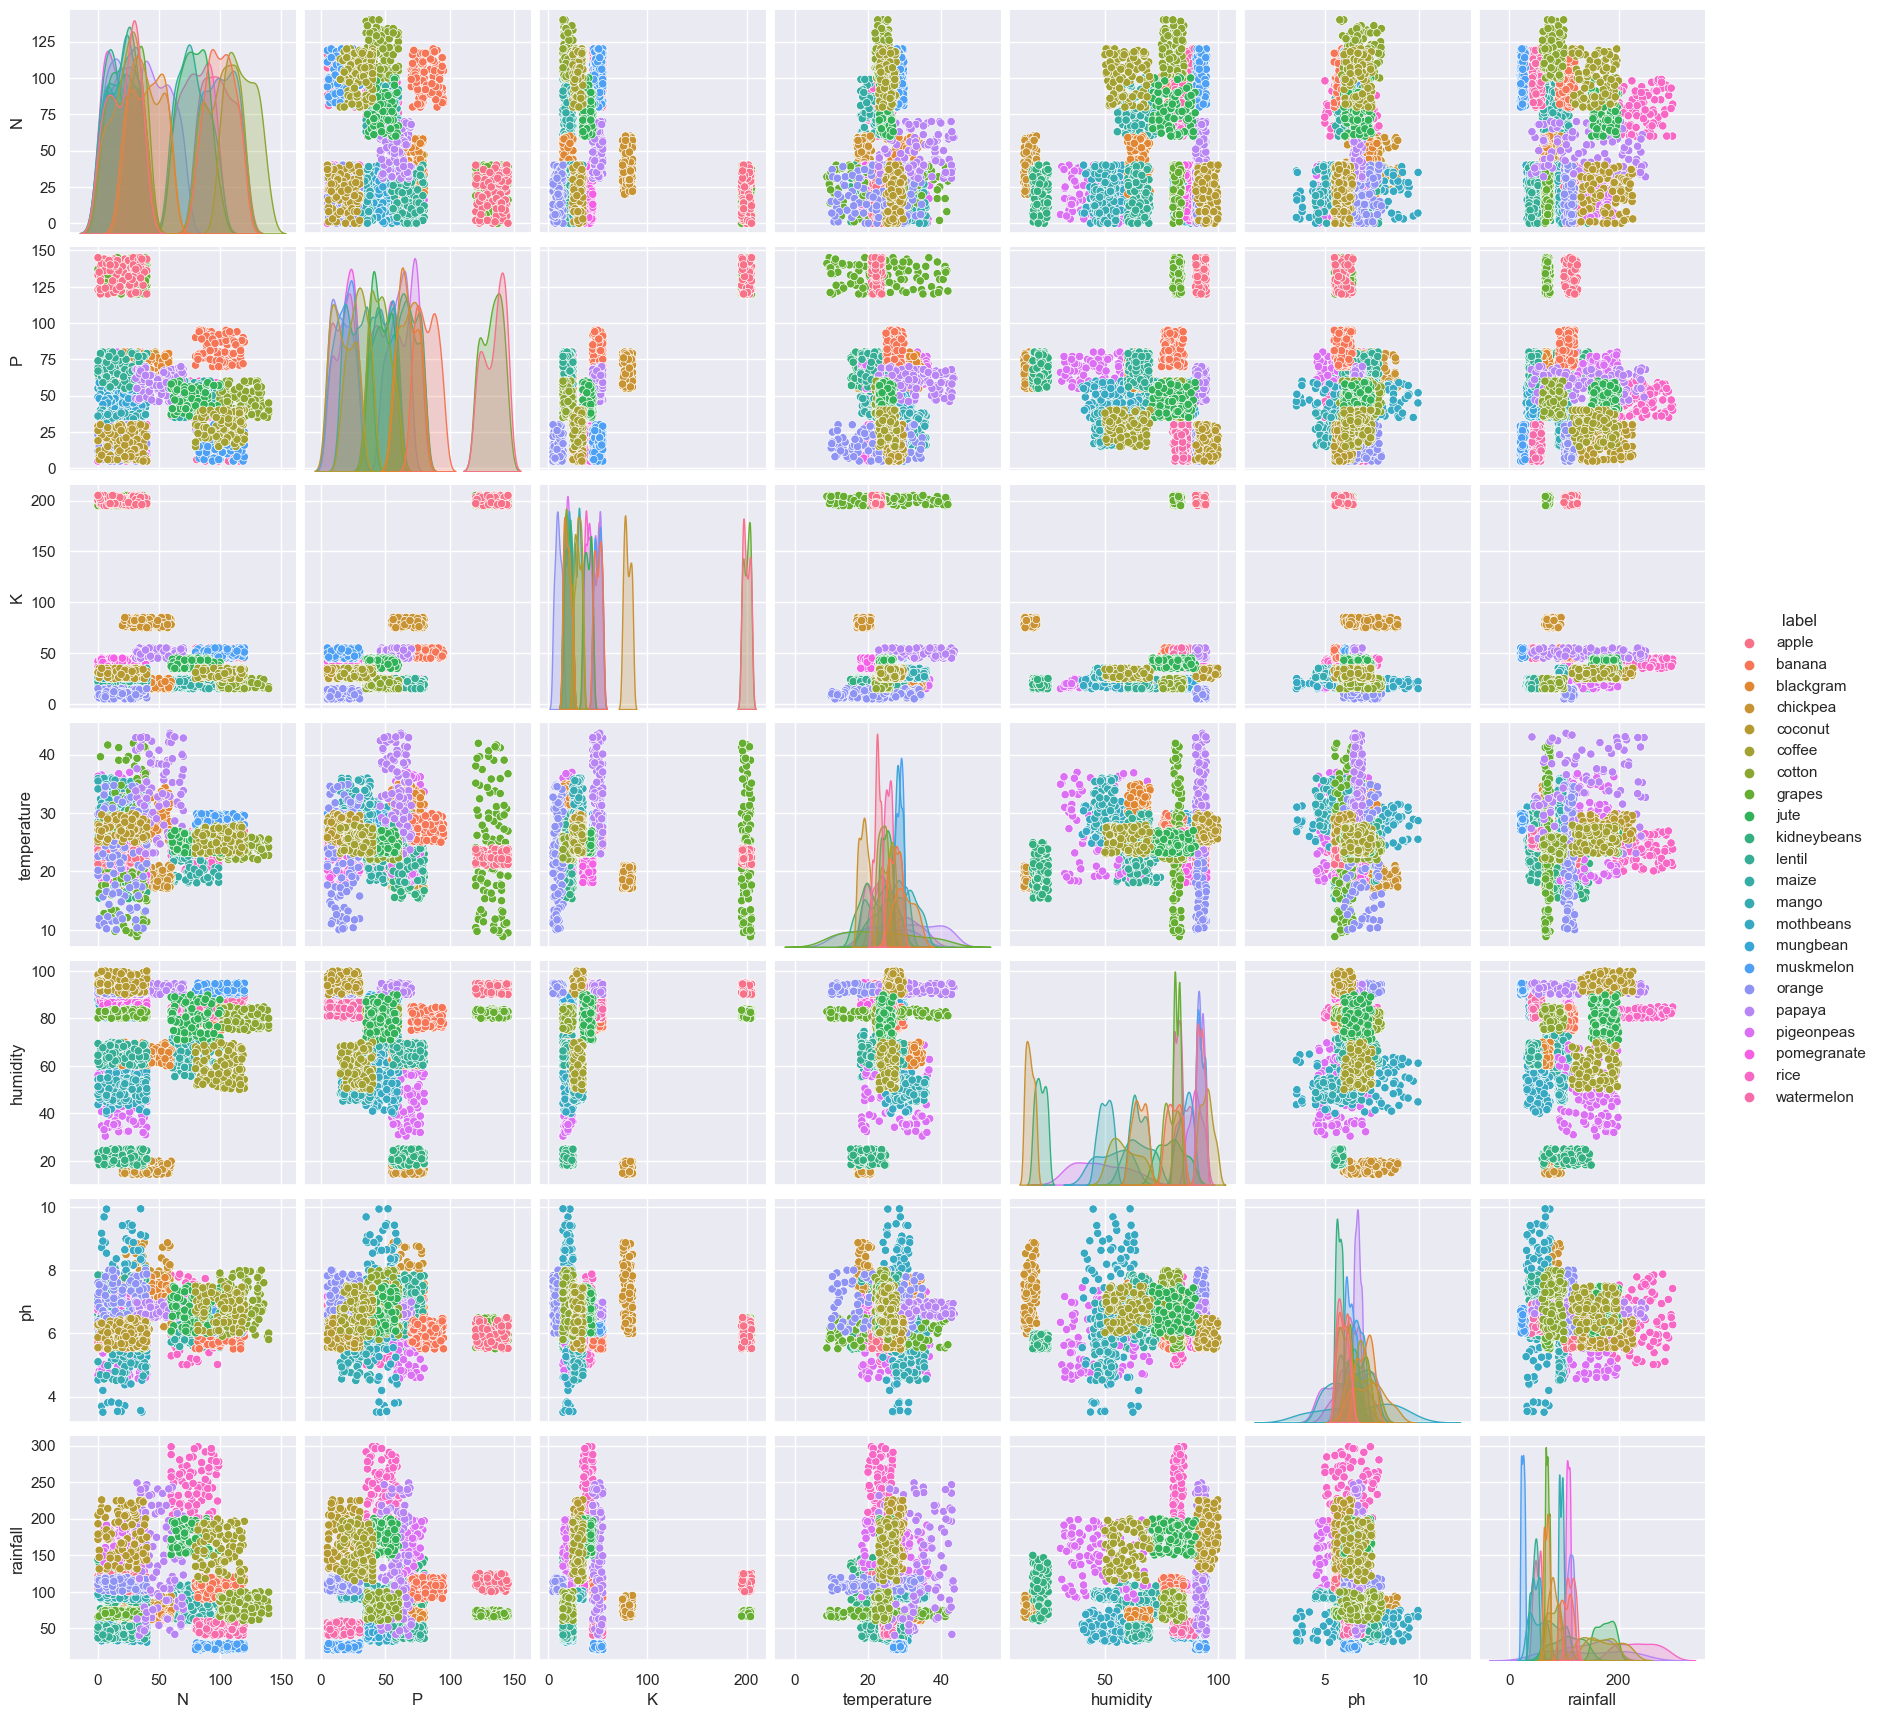

In [ ]:
sns.pairplot(mf, hue = 'label')
plt.show()

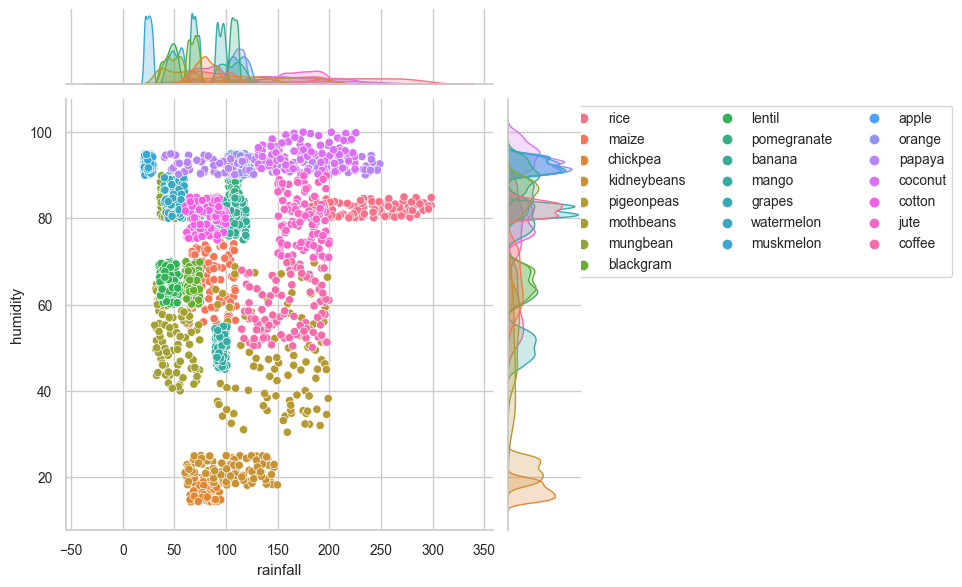

In [ ]:
sns.jointplot(x="rainfall", y="humidity", data=mf, hue="label")
plt.legend(bbox_to_anchor=(1.15, 1), ncol=3)
plt.show()

In [ ]:
X = mf.drop('label', axis=1)
y = mf.label.cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

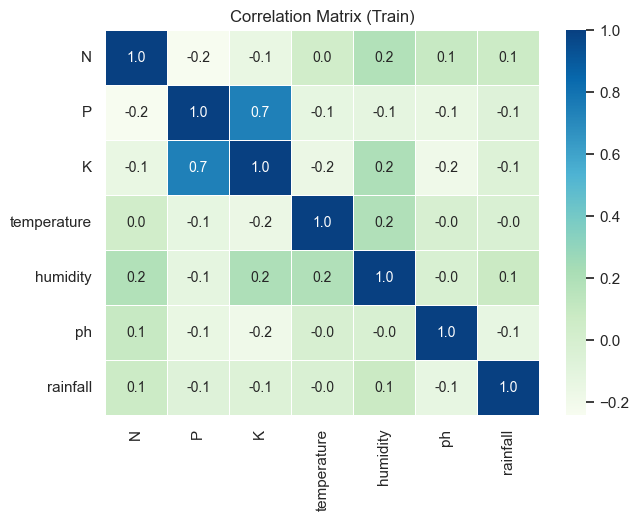

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

In [ ]:
estimator_names = ['RandomForestClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier',
                   'SVC', 'DummyClassifier']

#params_estimator = {'SVC':{'kernel':  ['poly', 'rbf', 'sigmoid']}}
for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('scaler', None),  # L'emplacement où la méthode de scaling sera insérée
        ('estimator', eval(estimator)())  # Le modèle que vous souhaitez entraîner
    ])
    parameters = [
        {'scaler': [None, StandardScaler(), MinMaxScaler()]},
    ]
    #parameters.append(params_estimator.get(estimator, {}))
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy", verbose=3)  # cv est le nombre de folds pour la validation croisée
    grid_search.fit(X_train, y_train)  # X sont vos données d'entraînement et y sont les étiquettes correspondantes
    #cv_results = grid_search.cv_results_

   
    print(estimator, grid_search.best_score_, grid_search.best_params_)  # Affiche la meilleure performance obtenue

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .......................scaler=None;, score=0.983 total time=   0.9s
[CV 2/5] END .......................scaler=None;, score=1.000 total time=   0.5s
[CV 3/5] END .......................scaler=None;, score=0.994 total time=   0.4s
[CV 4/5] END .......................scaler=None;, score=0.997 total time=   0.4s
[CV 5/5] END .......................scaler=None;, score=1.000 total time=   0.3s
[CV 1/5] END ...........scaler=StandardScaler();, score=0.986 total time=   0.3s
[CV 2/5] END ...........scaler=StandardScaler();, score=1.000 total time=   0.5s
[CV 3/5] END ...........scaler=StandardScaler();, score=0.994 total time=   0.3s
[CV 4/5] END ...........scaler=StandardScaler();, score=0.997 total time=   0.3s
[CV 5/5] END ...........scaler=StandardScaler();, score=1.000 total time=   0.3s
[CV 1/5] END .............scaler=MinMaxScaler();, score=0.983 total time=   0.3s
[CV 2/5] END .............scaler=MinMaxScaler();,

In [ ]:

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
test_score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print('RandomForestClassifier', round(test_score,2))
print(classification_report(y_test, y_pred, target_names=mf.label.cat.categories))


RandomForestClassifier 0.99
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14

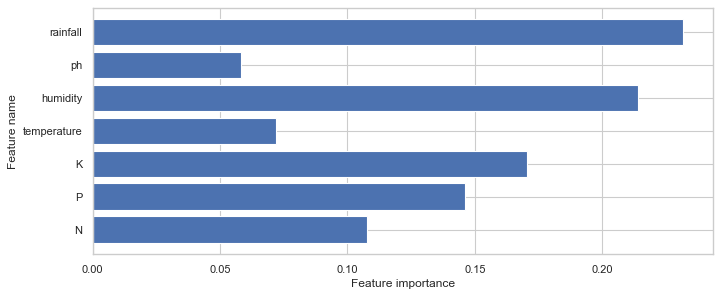

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), classifier.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()


In [ ]:
def plot_probabilities_heatmap(X_test, classifier, labels):
    sns.heatmap(classifier.predict_proba(X_test), cmap='viridis', xticklabels=labels, yticklabels=False, cbar=True).set(title='Predicted Probabilities')
    plt.show()
    
def plot_probalities_points(X_test, classifier, labels):
    sns.set(font_scale=0.9, style='whitegrid')
    tmp = pd.DataFrame(classifier.predict_proba(X_test), columns=labels)
    ix = tmp.quantile(0.90, 0).sort_values()
    tmp = tmp.loc[:, ix.index]
    sns.catplot(data=tmp, height=4, aspect=1.6, palette='tab20b').set(title='Predicted Probabilities')
    plt.xticks(rotation=90)
    plt.show()
    
def plot_confusion_matrix(X_test, y_test, classifier, labels):
    mat = confusion_matrix(y_test, classifier.predict(X_test))
    df_cm = pd.DataFrame(mat, list(labels), list(labels))
    sns.set(font_scale=1.0) # for label size
    fig, ax = plt.subplots(figsize=(8,5)) 
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap="terrain", ax=ax).set(title='Confusion Matrix')
    plt.show()
    


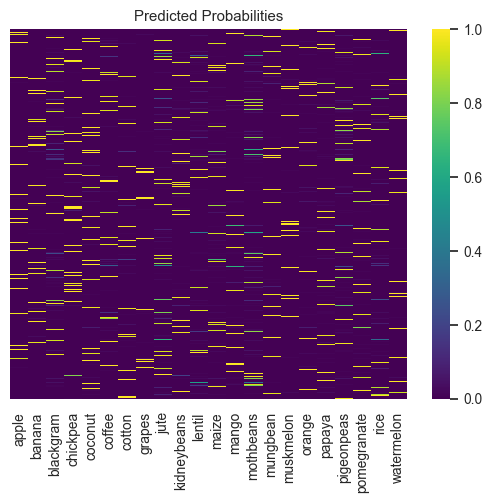

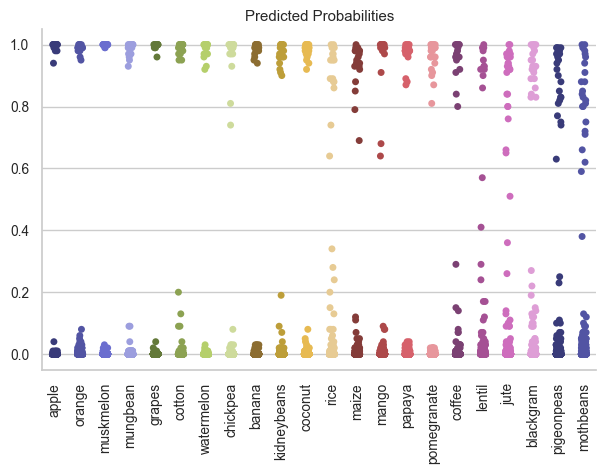

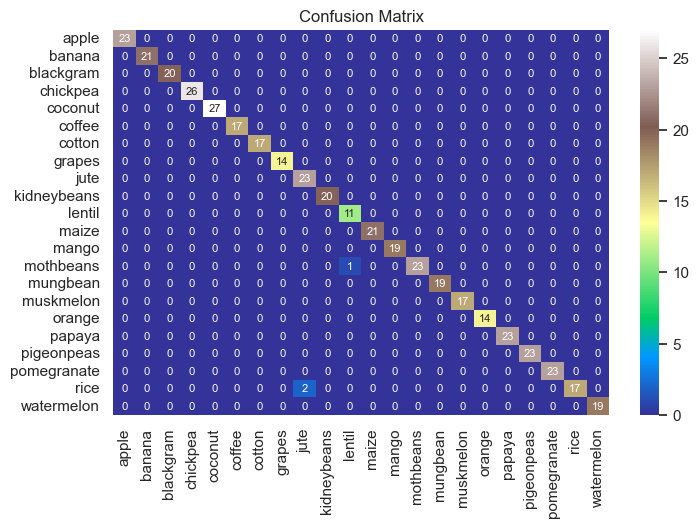

In [ ]:
labels = mf.label.cat.categories
plot_probabilities_heatmap(X_test, classifier, labels)
plot_probalities_points(X_test, classifier, labels)
plot_confusion_matrix(X_test, y_test, classifier, labels)

In [ ]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)
test_score = dummy_classifier.score(X_test, y_test)
y_pred = dummy_classifier.predict(X_test)
print('DummyClassifier', round(test_score,2))
print(classification_report(y_test, y_pred, target_names=mf.label.cat.categories))

DummyClassifier 0.02
              precision    recall  f1-score   support

       apple       0.00      0.00      0.00        23
      banana       0.00      0.00      0.00        21
   blackgram       0.00      0.00      0.00        20
    chickpea       0.00      0.00      0.00        26
     coconut       0.00      0.00      0.00        27
      coffee       0.00      0.00      0.00        17
      cotton       0.00      0.00      0.00        17
      grapes       0.00      0.00      0.00        14
        jute       0.00      0.00      0.00        23
 kidneybeans       0.00      0.00      0.00        20
      lentil       0.03      1.00      0.05        11
       maize       0.00      0.00      0.00        21
       mango       0.00      0.00      0.00        19
   mothbeans       0.00      0.00      0.00        24
    mungbean       0.00      0.00      0.00        19
   muskmelon       0.00      0.00      0.00        17
      orange       0.00      0.00      0.00        14
      

/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

* https://www.kaggle.com/code/altafk/real-time-crop-recommendation
* https://www.kaggle.com/code/ysthehurricane/crop-recommendation-system-using-lightgbm
* https://www.kaggle.com/code/atharvaingle/what-crop-to-grow
* https://github.com/the-pinbo/crop-prediction

In [ ]:
https://ubc-cs.github.io/cpsc330/lectures/02_decision-trees.html